<a href="https://colab.research.google.com/github/ravishankarramakrishnan/Deep_Learning_Practice/blob/master/0_CIFAR10_ANN_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the Libraries

In [1]:
# Importing the Data Processing Libraries
import pandas as pd
import numpy as np
import copy
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline

# Importing Dataset from Keras
from keras.datasets import cifar10

# Importing Deep Learning Libraries
import tensorflow as tf
import keras
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten, Dropout
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from keras.regularizers import l2

# Import Warnings to ignore them
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Verify the type of GPU allocated by Google Colab

!nvidia-smi

Fri Oct 16 09:22:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    24W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Data Loading, Processing and Visualisation

In [3]:
# Load Data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Validate their shapes
print("The Shape of X_train and X_test is", X_train.shape, X_test.shape)
print("The Shape of y_train and y_test is", y_train.shape, y_test.shape)

170500096/170498071 [==============================] - 6s 0us/step
The Shape of X_train and X_test is (50000, 32, 32, 3) (10000, 32, 32, 3)
The Shape of y_train and y_test is (50000, 1) (10000, 1)


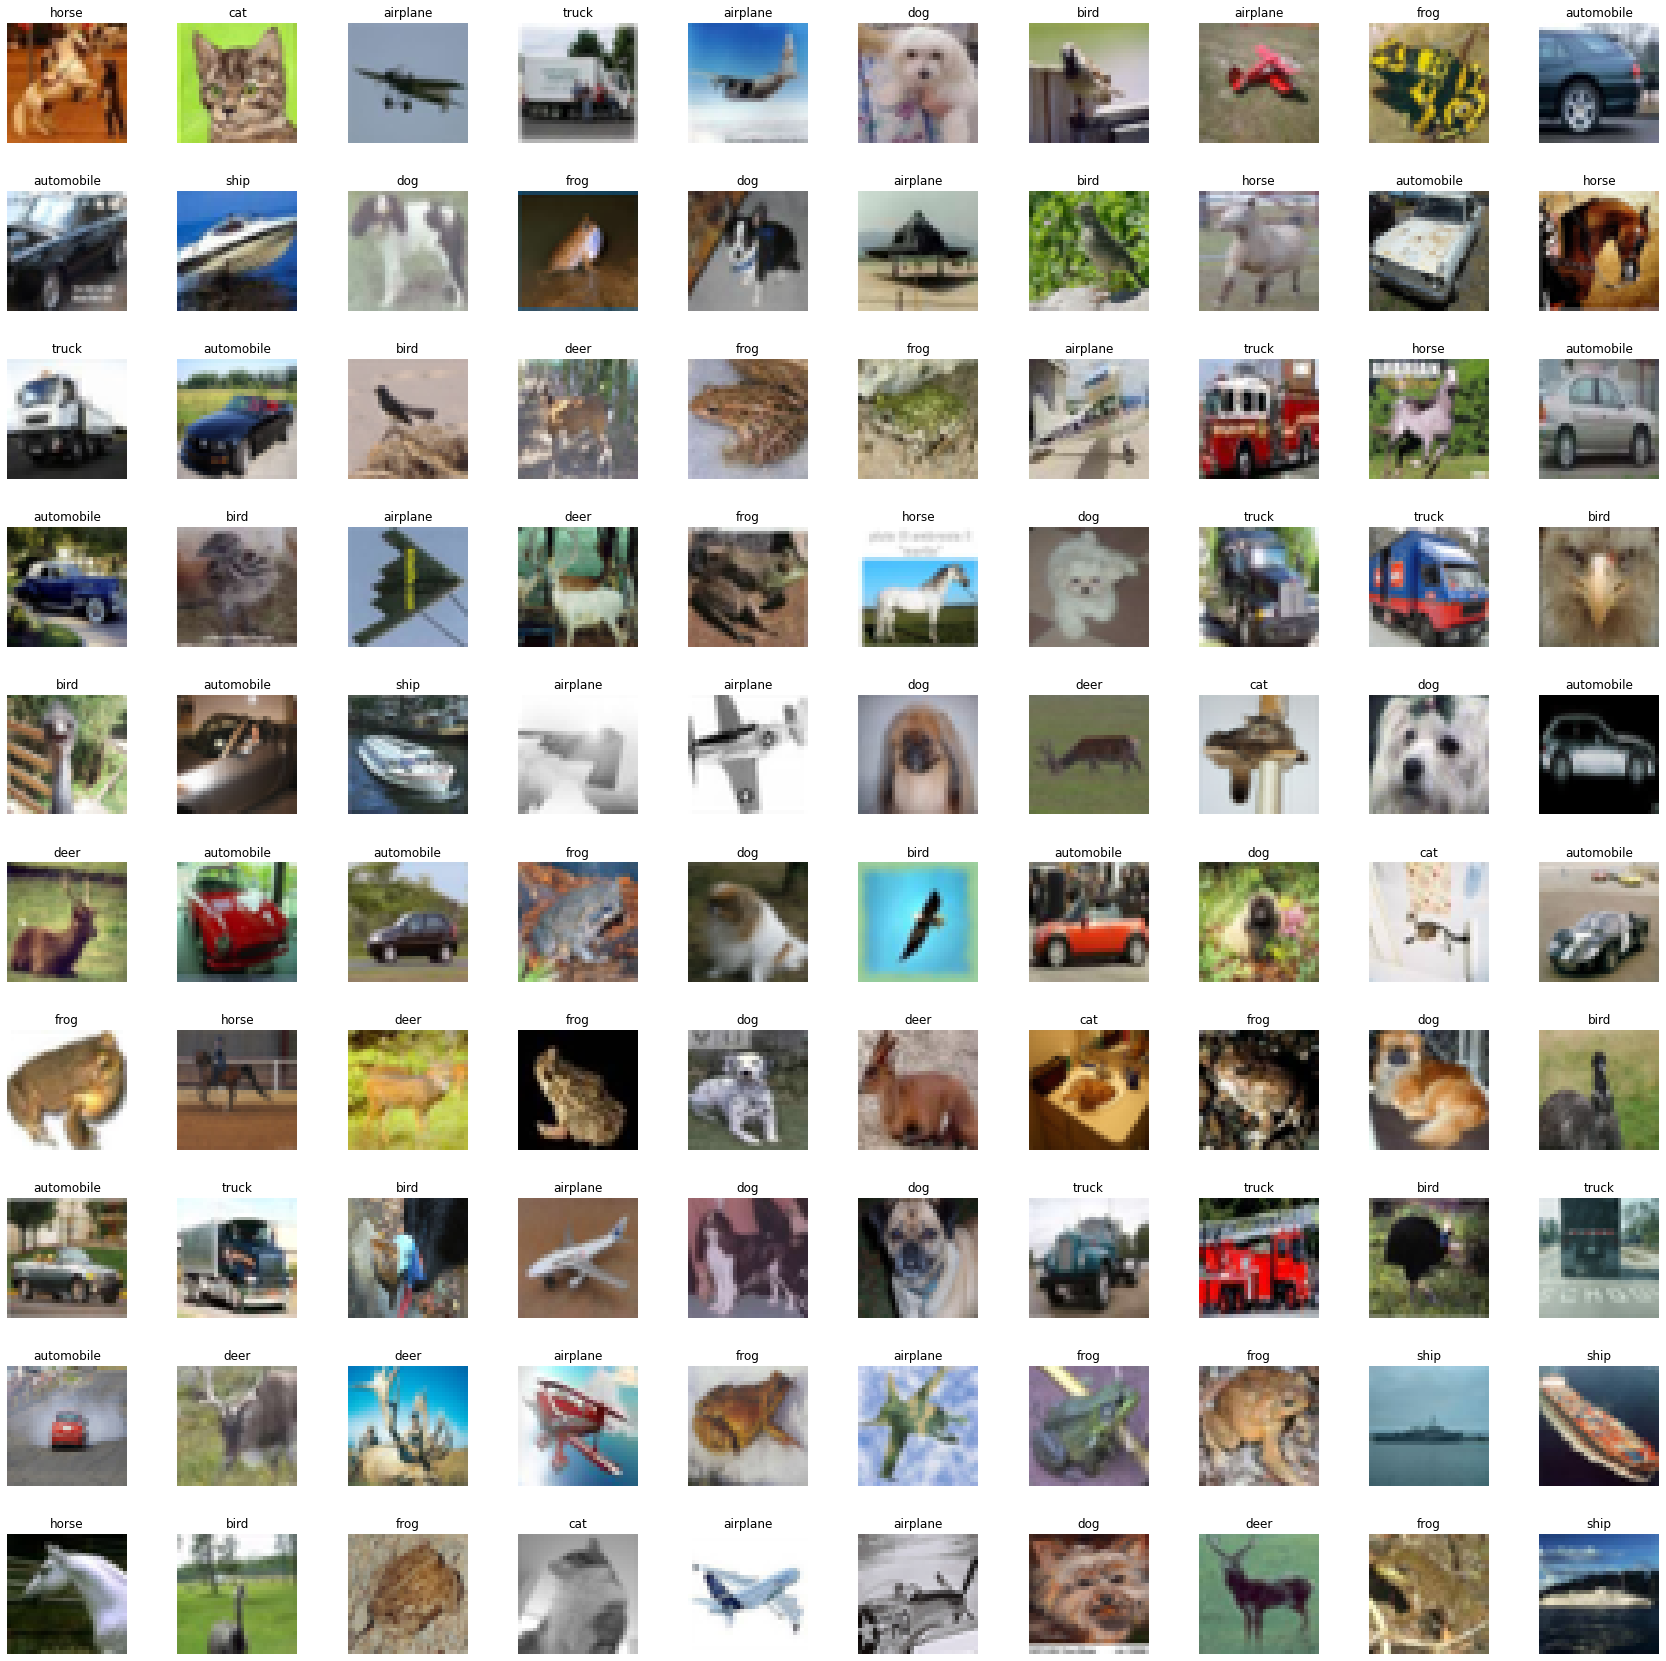

In [4]:
# Visualizing the Images

# Title for 10 images in the classes
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

# Show Multiple Images gridwise - Plotting images of Multiple classes

W_grid = 10
L_grid = 10
fig, axes = plt.subplots(L_grid, W_grid, figsize = (30,30))
axes = axes.ravel() # flatten the matrix into 25 arrays [5*5]  

n_train = len(X_train)

# Fill the Grid Images - 25 Images

for i in np.arange(0, L_grid*W_grid):
    index = np.random.randint(0, n_train)
    axes[i].imshow(X_train[index])
    # Add Label as title
    axes[i].set_title(classes[y_train[index][0]])
    # Remove axes of all images
    axes[i].axis('off')
  
# Set Horizontal Space for each plots
plt.subplots_adjust(hspace= 0.4);

In [5]:
# Data Preparation/Preprocessing
X_train = X_train.astype('float64')
X_test = X_test.astype('float64')

# Perform Data Normalisation (0 - 1 instead of 0 - 255)
X_train = X_train/255.
X_test = X_test/255.

# Convert Target variable from decimal to binary format

number_categories = 10
y_train = keras.utils.to_categorical(y_train, number_categories)
y_test = keras.utils.to_categorical(y_test, number_categories)

# Reshaping the X_train and y_train

X_train_reshaped = X_train.reshape(-1, 32*32*3)
X_test_reshaped = X_test.reshape(-1, 32*32*3)

# Take a copy of the Reshaped X and y for multiple models
X_train_reshaped_ANN, X_test_reshaped_ANN = X_train_reshaped[:], X_test_reshaped[:]
y_train_ANN, y_test_ANN = y_train[:], y_test[:]

X_train_reshaped_reg, X_test_reshaped_reg = X_train_reshaped[:], X_test_reshaped[:]
y_train_reg, y_test_reg = y_train[:], y_test[:]

X_train_reshaped_CNN, X_test_reshaped_CNN = X_train[:], X_test[:]
y_train_CNN, y_test_CNN = y_train[:], y_test[:]

# Validate them
print("X variable shapes are:")
print(X_train_reshaped.shape, X_test_reshaped.shape)
print(X_train_reshaped_ANN.shape, X_test_reshaped_ANN.shape)
print(X_train_reshaped_reg.shape, X_test_reshaped_reg.shape)
print(X_train_reshaped_CNN.shape, X_test_reshaped_CNN.shape)

print("y variable shapes are:")
print(y_train.shape, y_test.shape)
print(y_train_ANN.shape, y_test_ANN.shape)
print(y_train_reg.shape, y_test_reg.shape)
print(y_train_CNN.shape, y_test_CNN.shape)

X variable shapes are:
(50000, 3072) (10000, 3072)
(50000, 3072) (10000, 3072)
(50000, 3072) (10000, 3072)
(50000, 32, 32, 3) (10000, 32, 32, 3)
y variable shapes are:
(50000, 10) (10000, 10)
(50000, 10) (10000, 10)
(50000, 10) (10000, 10)
(50000, 10) (10000, 10)


# Model 1 - Artificial Neural Networks with Dropout, Regularisation and Early Stopping


In [6]:
# Define Artificial Neural Network Model

model_ann = tf.keras.models.Sequential()
# Add Fully Connected Hidden Layer
model_ann.add(tf.keras.layers.Dense(units=512, activation='relu', input_shape = (3072, ))) # Input Shape Needed only at First FC Layer
# Add Another Fully Connected Hidden Layer
model_ann.add(tf.keras.layers.Dense(units=256, kernel_regularizer=l2(0.01), activation='relu'))
# Add Another Fully Connected Hidden Layer
model_ann.add(tf.keras.layers.Dense(units=128, kernel_regularizer=l2(0.01), activation='relu'))
# Add Another Fully Connected Hidden Layer
model_ann.add(tf.keras.layers.Dense(units=64, kernel_regularizer=l2(0.01), activation='relu'))
# Add Second Layer with Dropout
model_ann.add(tf.keras.layers.Dropout(0.2))
# Add output Layer
model_ann.add(tf.keras.layers.Dense(10, activation='softmax'))

# Get Model Architecture
model_ann.summary()

# Compile the Model
model_ann.compile(optimizer= 'adam', loss= 'categorical_crossentropy', metrics= ['accuracy'])
# Build Early Stopping
earlystopping = EarlyStopping(monitor= "val_loss", patience= 5, verbose= 1, mode='min')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               1573376   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 1,746,506
Trainable params: 1,746,506
Non-trainable params: 0
______________________________________________

In [7]:
# Training the ANN Model

# Fit training data to Model
start = time.time()
history_ann = model_ann.fit(X_train_reshaped_ANN, y_train_ANN, epochs= 25, validation_data=(X_test_reshaped_ANN, y_test_ANN), callbacks= [earlystopping])
end = time.time()
print("Time taken for training the ANN Model - 1 is {} minutes".format(round((end - start)/60, 2)))

Epoch 1/25
1563/1563 [==============================] - 10s 6ms/step - loss: 2.3288 - accuracy: 0.2877 - val_loss: 1.8330 - val_accuracy: 0.3596
Epoch 2/25
1563/1563 [==============================] - 9s 6ms/step - loss: 1.8488 - accuracy: 0.3515 - val_loss: 1.7566 - val_accuracy: 0.3852
Epoch 3/25
1563/1563 [==============================] - 9s 6ms/step - loss: 1.7697 - accuracy: 0.3823 - val_loss: 1.6877 - val_accuracy: 0.4087
Epoch 4/25
1563/1563 [==============================] - 9s 6ms/step - loss: 1.7180 - accuracy: 0.4013 - val_loss: 1.6482 - val_accuracy: 0.4221
Epoch 5/25
1563/1563 [==============================] - 9s 6ms/step - loss: 1.6816 - accuracy: 0.4158 - val_loss: 1.6873 - val_accuracy: 0.4139
Epoch 6/25
1563/1563 [==============================] - 9s 6ms/step - loss: 1.6529 - accuracy: 0.4273 - val_loss: 1.6333 - val_accuracy: 0.4430
Epoch 7/25
1563/1563 [==============================] - 10s 6ms/step - loss: 1.6237 - accuracy: 0.4412 - val_loss: 1.5756 - val_accurac

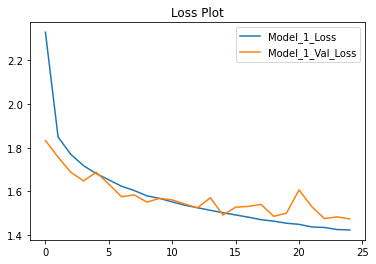

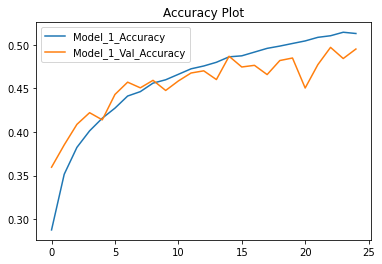

In [8]:
# Plot the History Loss and Accuracy

import matplotlib.pyplot as plt
plt.plot(history_ann.history['loss'], label="Model_1_Loss")
plt.plot(history_ann.history['val_loss'], label="Model_1_Val_Loss")
plt.title("Loss Plot")
plt.legend();
plt.show();

# Plot the Accuracy
plt.plot(history_ann.history['accuracy'], label="Model_1_Accuracy")
plt.plot(history_ann.history['val_accuracy'], label="Model_1_Val_Accuracy")
plt.title("Accuracy Plot")
plt.legend();
plt.show();

In [9]:
# Evaluating the ANN Model performance on the Test set

evals_ANN = model_ann.evaluate(X_test_reshaped_ANN, y_test_ANN)
print("The Test accuracy for Model 1 is: {}".format(round(evals_ANN[1], 2)))
print("The Test Loss  for Model 1 is: {}".format(round(evals_ANN[0], 2)))

313/313 [==============================] - 1s 3ms/step - loss: 1.4738 - accuracy: 0.4951
The Test accuracy for Model 1 is: 0.5
The Test Loss  for Model 1 is: 1.47


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


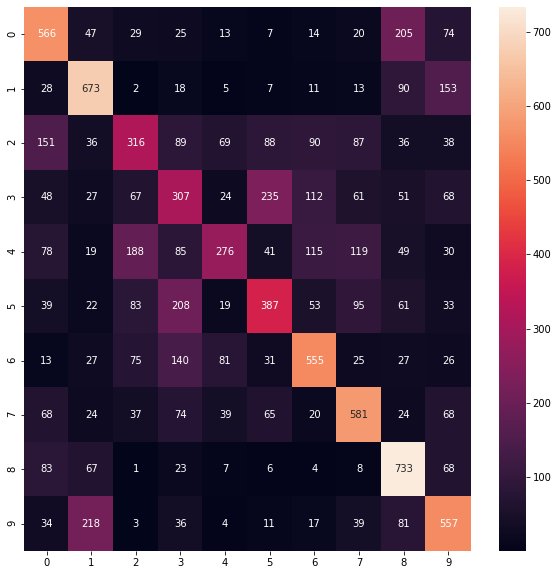

              precision    recall  f1-score   support

           0       0.51      0.57      0.54      1000
           1       0.58      0.67      0.62      1000
           2       0.39      0.32      0.35      1000
           3       0.31      0.31      0.31      1000
           4       0.51      0.28      0.36      1000
           5       0.44      0.39      0.41      1000
           6       0.56      0.56      0.56      1000
           7       0.55      0.58      0.57      1000
           8       0.54      0.73      0.62      1000
           9       0.50      0.56      0.53      1000

    accuracy                           0.50     10000
   macro avg       0.49      0.50      0.49     10000
weighted avg       0.49      0.50      0.49     10000



In [10]:
# Prediction
pred_class_ANN = model_ann.predict_classes(X_test_reshaped_ANN)

# Return Y_test from Sparse to max value (Boolean to Decimal for Comparison)
y_test_ANN = y_test_ANN.argmax(1)

# Use Confusion Matrix to Summarize
cm = confusion_matrix(y_test_ANN, pred_class_ANN)
plt.figure(figsize= (10,10))
sns.heatmap(cm, annot= True, fmt= "0.0f");
plt.show();

# Classification Report
print(classification_report(y_test_ANN, pred_class_ANN))

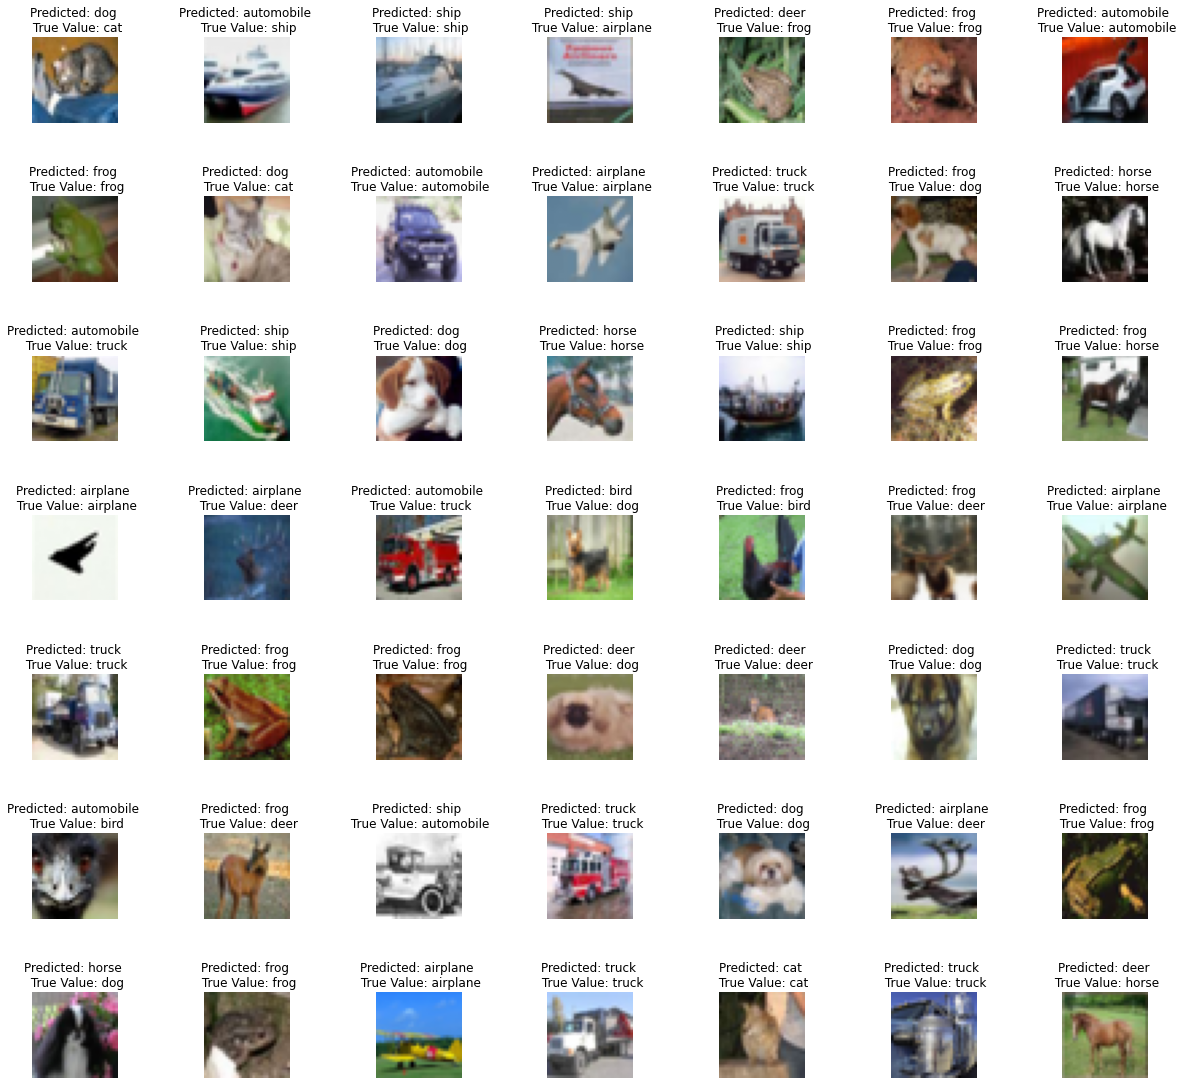

In [11]:
# Plot the Predictions vs Actual - Model 1

# Show the Matrix

leng = 7
wid = 7
fig, axes = plt.subplots(leng, wid, figsize = (20,20))
axes = axes.ravel()

# Loop through and check Multiclass values

for i in np.arange(0, leng*wid):
    axes[i].imshow(X_test[i])
    axes[i].set_title('Predicted: {} \n True Value: {}'.format(classes[pred_class_ANN[i]], classes[y_test_ANN[i]]))
    axes[i].axis('off')

plt.subplots_adjust(wspace= 1)

# Model 2 - Artificial Neural Networks without Regularisation and Early Stopping

In [12]:
# Define Artificial Neural Network Model - No Regularisation and different dropout

model_reg = tf.keras.models.Sequential()
# Add Fully Connected Hidden Layer
model_reg.add(tf.keras.layers.Dense(units=512, activation='relu', input_shape = (3072, ))) # Input Shape Needed only at First FC Layer
# Add Another Fully Connected Hidden Layer
model_reg.add(tf.keras.layers.Dense(units=256, activation='relu'))
# Add Another Fully Connected Hidden Layer
model_reg.add(tf.keras.layers.Dense(units=128, activation='relu'))
# Add Second Layer with Dropout
model_reg.add(tf.keras.layers.Dropout(0.3))
# Add Another Fully Connected Hidden Layer
model_reg.add(tf.keras.layers.Dense(units=64, activation='relu'))
# Add output Layer
model_reg.add(tf.keras.layers.Dense(10, activation='softmax'))

# Get Model Architecture
model_reg.summary()

# Compile the Model
model_reg.compile(optimizer= 'adam', loss= 'categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               1573376   
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 10)                650       
Total params: 1,746,506
Trainable params: 1,746,506
Non-trainable params: 0
____________________________________________

In [13]:
# Training the ANN Model 2

# Fit training data to Model 2
start = time.time()
history_reg = model_reg.fit(X_train_reshaped_reg, y_train_reg, epochs= 25, validation_data=(X_test_reshaped_reg, y_test_reg))
end = time.time()
print("Time taken for training the ANN Model - 2 is {} minutes".format(round((end - start)/60, 2)))

Epoch 1/25
1563/1563 [==============================] - 9s 6ms/step - loss: 1.9624 - accuracy: 0.2748 - val_loss: 1.7718 - val_accuracy: 0.3574
Epoch 2/25
1563/1563 [==============================] - 9s 5ms/step - loss: 1.7725 - accuracy: 0.3601 - val_loss: 1.6911 - val_accuracy: 0.3861
Epoch 3/25
1563/1563 [==============================] - 9s 5ms/step - loss: 1.6949 - accuracy: 0.3902 - val_loss: 1.6281 - val_accuracy: 0.4148
Epoch 4/25
1563/1563 [==============================] - 9s 5ms/step - loss: 1.6422 - accuracy: 0.4103 - val_loss: 1.5813 - val_accuracy: 0.4343
Epoch 5/25
1563/1563 [==============================] - 9s 6ms/step - loss: 1.6127 - accuracy: 0.4237 - val_loss: 1.5578 - val_accuracy: 0.4406
Epoch 6/25
1563/1563 [==============================] - 9s 5ms/step - loss: 1.5882 - accuracy: 0.4311 - val_loss: 1.5452 - val_accuracy: 0.4433
Epoch 7/25
1563/1563 [==============================] - 9s 5ms/step - loss: 1.5674 - accuracy: 0.4384 - val_loss: 1.5920 - val_accuracy:

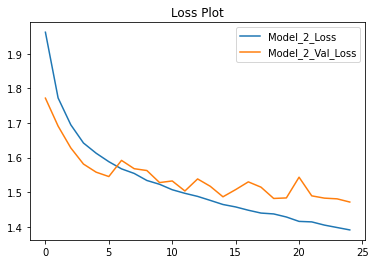

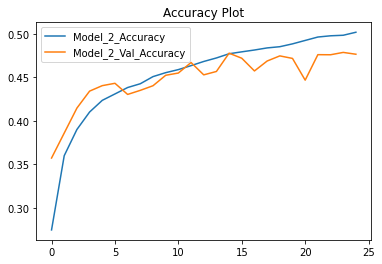

In [14]:
# Plot the History Loss and Accuracy for Model 2

import matplotlib.pyplot as plt
plt.plot(history_reg.history['loss'], label="Model_2_Loss")
plt.plot(history_reg.history['val_loss'], label="Model_2_Val_Loss")
plt.title("Loss Plot")
plt.legend();
plt.show();

# Plot the Accuracy
plt.plot(history_reg.history['accuracy'], label="Model_2_Accuracy")
plt.plot(history_reg.history['val_accuracy'], label="Model_2_Val_Accuracy")
plt.title("Accuracy Plot")
plt.legend();
plt.show();

In [15]:
# Evaluating the ANN Model performance on the Test set

evals_reg = model_reg.evaluate(X_test_reshaped_reg, y_test_reg)
print("The Test accuracy for Model 2 is: {}".format(round(evals_reg[1], 2)))
print("The Test Loss  for Model 2 is: {}".format(round(evals_reg[0], 2)))

313/313 [==============================] - 1s 3ms/step - loss: 1.4715 - accuracy: 0.4767
The Test accuracy for Model 2 is: 0.48
The Test Loss  for Model 2 is: 1.47


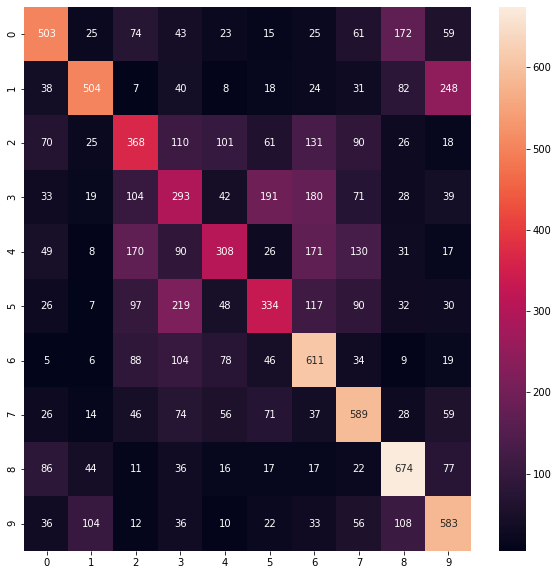

              precision    recall  f1-score   support

           0       0.58      0.50      0.54      1000
           1       0.67      0.50      0.57      1000
           2       0.38      0.37      0.37      1000
           3       0.28      0.29      0.29      1000
           4       0.45      0.31      0.36      1000
           5       0.42      0.33      0.37      1000
           6       0.45      0.61      0.52      1000
           7       0.50      0.59      0.54      1000
           8       0.57      0.67      0.62      1000
           9       0.51      0.58      0.54      1000

    accuracy                           0.48     10000
   macro avg       0.48      0.48      0.47     10000
weighted avg       0.48      0.48      0.47     10000



In [16]:
# Prediction
pred_class_reg = model_reg.predict_classes(X_test_reshaped_reg)

# Return Y_test from Sparse to max value (Boolean to Decimal for Comparison)
y_test_reg = y_test_reg.argmax(1)

# Use Confusion Matrix to Summarize
cm = confusion_matrix(y_test_reg, pred_class_reg)
plt.figure(figsize= (10,10))
sns.heatmap(cm, annot= True, fmt= "0.0f");
plt.show();

# Classification Report
print(classification_report(y_test_reg, pred_class_reg))

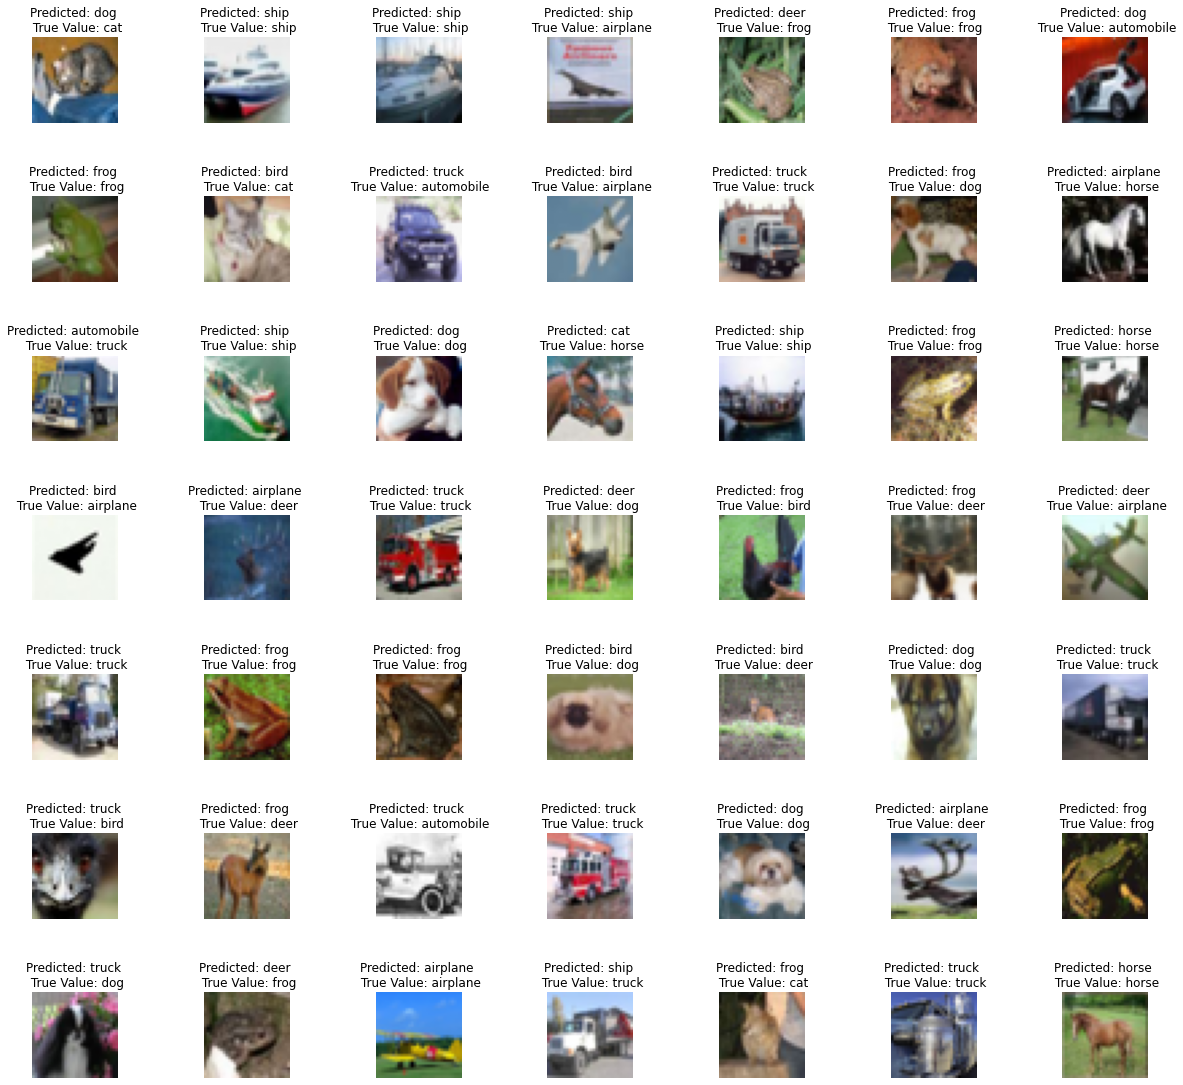

In [17]:
# Plot the Predictions vs Actual - Model 2

# Show the Matrix

leng = 7
wid = 7
fig, axes = plt.subplots(leng, wid, figsize = (20,20))
axes = axes.ravel()

# Loop through and check Multiclass values

for i in np.arange(0, leng*wid):
    axes[i].imshow(X_test[i])
    axes[i].set_title('Predicted: {} \n True Value: {}'.format(classes[pred_class_reg[i]], classes[y_test_reg[i]]))
    axes[i].axis('off')

plt.subplots_adjust(wspace= 1)

# Model 3 - Convolution Neural Networks

In [18]:
# Convolutional Dataset Processing

print(X_train_reshaped_CNN.shape)
Input_shape = X_train_reshaped_CNN.shape[1:] 
print(Input_shape)

(50000, 32, 32, 3)
(32, 32, 3)


In [19]:
# Using Convolutional Neural Networks

# Initiate as per Sequence
model_CNN = Sequential()
# Building First Convolution Layer
model_CNN.add(Conv2D(filters=64, kernel_size= (3,3), activation= 'relu', input_shape = Input_shape))
# Building Second Convolution Layer
model_CNN.add(Conv2D(filters=64, kernel_size= (3,3), activation= 'relu'))
# Adding Max Pooling
model_CNN.add(MaxPooling2D(pool_size= (2,2)))
# Add Dropout
model_CNN.add(Dropout(0.3))
# Build Another Layer of Convolution with 128 filters - To increase the Depth of the Neural Networks
model_CNN.add(Conv2D(filters=128, kernel_size= (3,3), kernel_regularizer=l2(0.01), activation= 'relu'))
model_CNN.add(Conv2D(filters=128, kernel_size= (3,3), kernel_regularizer=l2(0.01), activation= 'relu'))
model_CNN.add(MaxPooling2D(pool_size= (2,2)))
model_CNN.add(Dropout(0.2))
# Flatten the Model
model_CNN.add(Flatten())
# Add Dense Fully Connected Layer
model_CNN.add(Dense(units=1024, activation='relu'))
# Add another Hidden Layer
model_CNN.add(Dense(units=1024, activation='relu'))
# Add Output Layer
model_CNN.add(Dense(units = 10, activation= 'softmax'))

# Get the Model summary
model_CNN.summary()
# Compiling and Fitting the Data
model_CNN.compile(loss= 'categorical_crossentropy', optimizer= keras.optimizers.RMSprop(lr = 0.001), metrics=['accuracy'])
# Build Early Stopping
earlystopping = EarlyStopping(monitor= "val_loss", patience= 5, verbose= 1, mode='min')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 128)        

In [20]:
# Fit training data to Model 3 - CNN
start = time.time()
history_CNN = model_CNN.fit(X_train_reshaped_CNN, y_train_CNN, validation_data=(X_test_reshaped_CNN, y_test_CNN),
                            batch_size= 128, epochs = 25, shuffle= True,callbacks= [earlystopping])
end = time.time()
print("Time taken for training CNN Model - 3 is {} minutes".format(round((end - start)/60, 2)))

Epoch 1/25
391/391 [==============================] - 15s 38ms/step - loss: 2.0584 - accuracy: 0.2915 - val_loss: 1.6505 - val_accuracy: 0.4167
Epoch 2/25
391/391 [==============================] - 14s 36ms/step - loss: 1.5353 - accuracy: 0.4593 - val_loss: 1.4477 - val_accuracy: 0.4868
Epoch 3/25
391/391 [==============================] - 14s 36ms/step - loss: 1.3576 - accuracy: 0.5327 - val_loss: 1.3277 - val_accuracy: 0.5476
Epoch 4/25
391/391 [==============================] - 14s 36ms/step - loss: 1.2271 - accuracy: 0.5818 - val_loss: 1.3091 - val_accuracy: 0.5710
Epoch 5/25
391/391 [==============================] - 14s 36ms/step - loss: 1.1326 - accuracy: 0.6210 - val_loss: 1.2860 - val_accuracy: 0.5709
Epoch 6/25
391/391 [==============================] - 14s 36ms/step - loss: 1.0522 - accuracy: 0.6526 - val_loss: 1.0412 - val_accuracy: 0.6551
Epoch 7/25
391/391 [==============================] - 14s 37ms/step - loss: 0.9795 - accuracy: 0.6805 - val_loss: 1.0306 - val_accuracy:

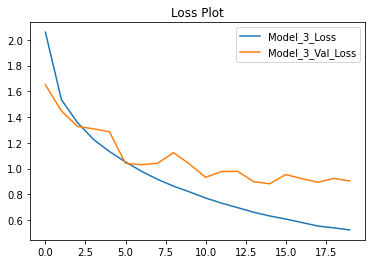

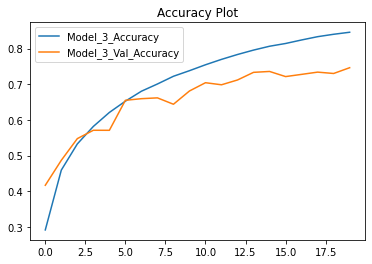

In [22]:
# Plot CNN Model Accuracy and Loss

import matplotlib.pyplot as plt
plt.plot(history_CNN.history['loss'], label="Model_3_Loss")
plt.plot(history_CNN.history['val_loss'], label="Model_3_Val_Loss")
plt.title("Loss Plot")
plt.legend();
plt.show();

# Plot the Accuracy
plt.plot(history_CNN.history['accuracy'], label="Model_3_Accuracy")
plt.plot(history_CNN.history['val_accuracy'], label="Model_3_Val_Accuracy")
plt.title("Accuracy Plot")
plt.legend();
plt.show();

In [23]:
# Evaluating the CNN Model performance on the Test set

evals_CNN = model_CNN.evaluate(X_test_reshaped_CNN, y_test_CNN)
print("The Test accuracy for CNN Model is: {}".format(round(evals_CNN[1], 2)))
print("The Test Loss  for CNN Model is: {}".format(round(evals_CNN[0], 2)))

313/313 [==============================] - 2s 7ms/step - loss: 0.9051 - accuracy: 0.7465
The Test accuracy for CNN Model is: 0.75
The Test Loss  for CNN Model is: 0.91


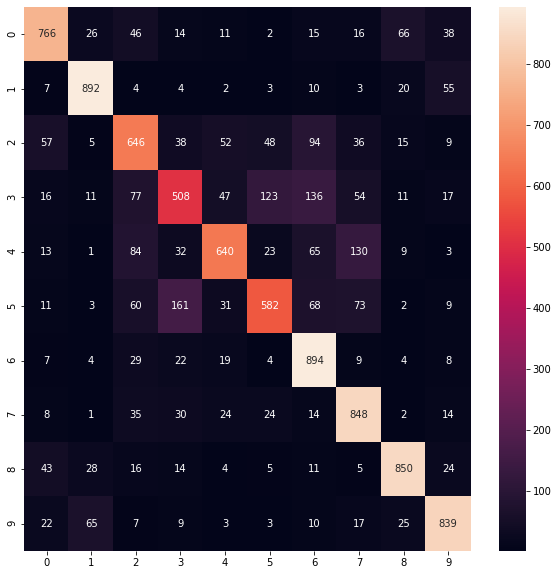

              precision    recall  f1-score   support

           0       0.81      0.77      0.79      1000
           1       0.86      0.89      0.88      1000
           2       0.64      0.65      0.64      1000
           3       0.61      0.51      0.55      1000
           4       0.77      0.64      0.70      1000
           5       0.71      0.58      0.64      1000
           6       0.68      0.89      0.77      1000
           7       0.71      0.85      0.77      1000
           8       0.85      0.85      0.85      1000
           9       0.83      0.84      0.83      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.74     10000
weighted avg       0.75      0.75      0.74     10000



In [24]:
# Prediction - CNN Model
pred_class_CNN = model_CNN.predict_classes(X_test_reshaped_CNN)

# Return Y_test from Sparse to max value (Boolean to Decimal for Comparison)
y_test_CNN = y_test_CNN.argmax(1)

# Use Confusion Matrix to Summarize
cm = confusion_matrix(y_test_CNN, pred_class_CNN)
plt.figure(figsize= (10,10))
sns.heatmap(cm, annot= True, fmt= "0.0f");
plt.show();

# Classification Report
print(classification_report(y_test_CNN, pred_class_CNN))

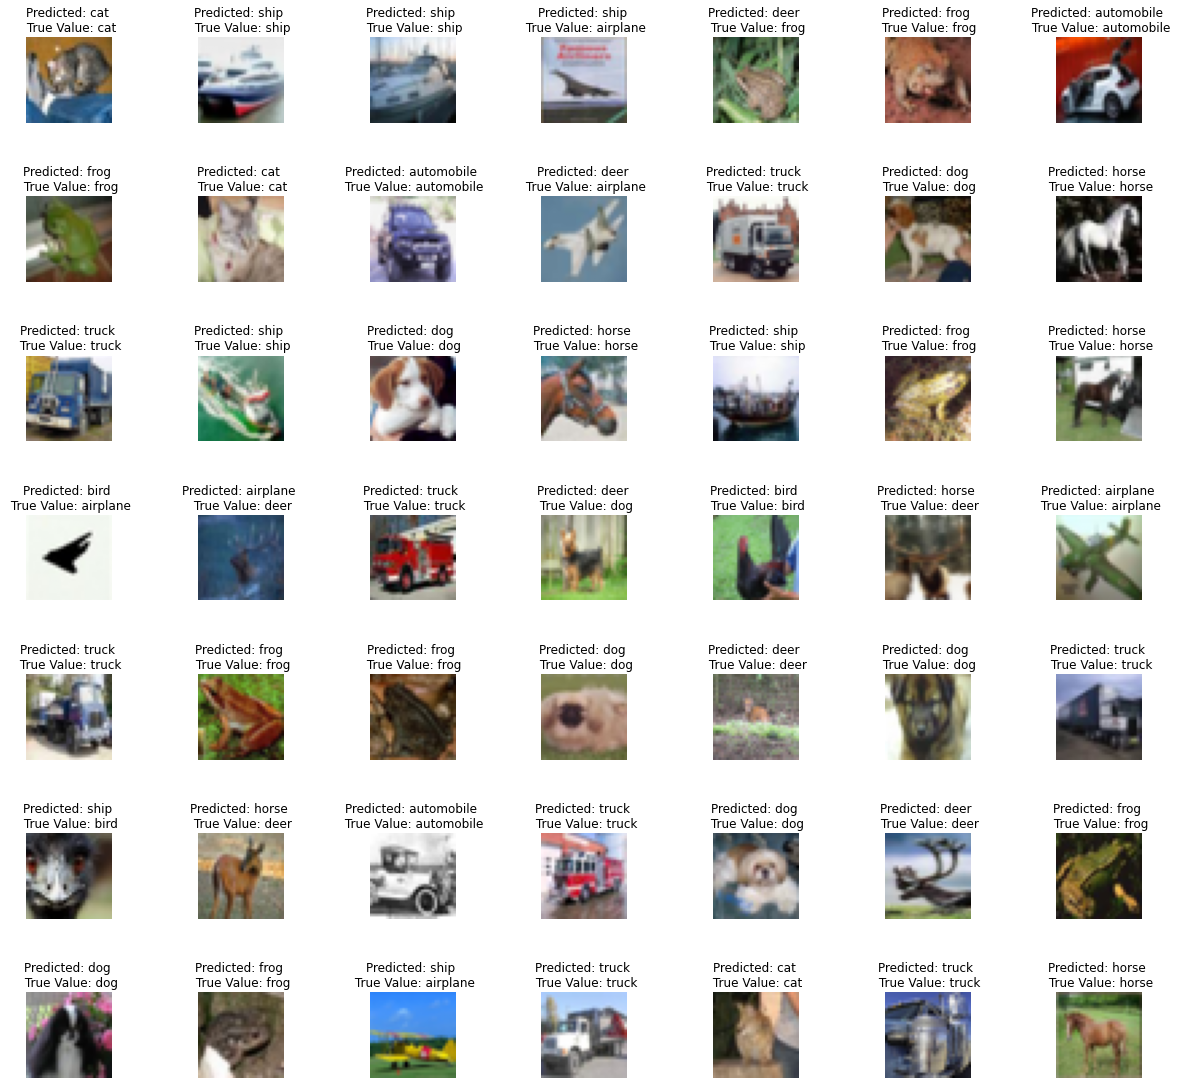

In [25]:
# Plot the Predictions vs Actual - CNN Model 3

# Show the Matrix

leng = 7
wid = 7
fig, axes = plt.subplots(leng, wid, figsize = (20,20))
axes = axes.ravel()

# Loop through and check Multiclass values

for i in np.arange(0, leng*wid):
    axes[i].imshow(X_test[i])
    axes[i].set_title('Predicted: {} \n True Value: {}'.format(classes[pred_class_CNN[i]], classes[y_test_CNN[i]]))
    axes[i].axis('off')

plt.subplots_adjust(wspace= 1)

# Thank you!